In [822]:
%matplotlib inline
import json
import pylab
import copy
from pprint import pprint
import numpy as np
from lxml import etree
import matplotlib.colors
from pysurvey.plot import icolorbar, text, box
from pysurvey.plot import setup_sns as setup

import seaborn as sns
sns.set_style('white')

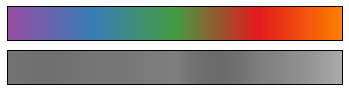

In [576]:
def make_cmap():
    # from brewer -- reorganized
    rgbs = (
        (152,78,163),
        (55,126,184),
        #(77,175,74),
        (69, 157, 66),
        (228,26,28),
        (255,127,0),
    )
    cdict = {}
    colors = ['red', 'green', 'blue']
    for i,rgb in enumerate(rgbs):
        for color,value in zip(colors, rgb):
            c = cdict.get(color, [])
            c.append((i*1.0/(len(rgbs)-1.0), value/256.0, value/256.0))
            cdict[color] = c
    # Darken Rainbow
#     def c(name):
#         return lambda x: np.clip(pylab.cm.datad['rainbow'][name](x),0,0.8)
#     cdict = dict(
#         red = c('red'),
#         green = c('green'),
#         blue = c('blue'),
#     )
    cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,512)
    return cmap

def grayify_cmap(cmap):
    colors = cmap(np.arange(cmap.N))
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    return cmap.from_list(cmap.name + "_grayscale", colors, cmap.N)

def show_colormap(cmap):
    im = np.outer(np.ones(10), np.arange(100))
    fig, ax = pylab.subplots(2, figsize=(6, 1.5), subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.1)
    ax[0].imshow(im, cmap=cmap)
    ax[1].imshow(im, cmap=grayify_cmap(cmap))
    
show_colormap(make_cmap())


In [635]:
with open('/Users/ajmendez/data/reddit/subreddit_ages.json', 'r') as f:
    subreddit_map = json.load(f)
ages = [v[0] for k,v in subreddit_map.iteritems()]
np.min(ages), np.max(ages)

(14.0, 40.0)

In [638]:
# This was the original one, but lets update to the clustering version
tree = etree.parse("/Users/ajmendez/data/reddit/subreddits.gexf", base_url='http://www.gexf.net/1.2draft')
ns = {'graph': '{http://www.gexf.net/1.2draft}graph'}
graph = tree.getroot().find(ns['graph'])
#         tag = graph.findall('.*//*[@label="{}"]'.format(subreddit))[0]
#     s = tag[1].attrib
#     p = tag[2].attrib
# int(tag.attrib['id']),


In [875]:
# Programming subreddits compiled from:
# https://www.reddit.com/user/krispykrackers/m/programming
# https://www.reddit.com/comments/a6qgz/proggit_im_trying_to_compile_all_the_known


city_subreddits = ('orlando Quebec Colorado Calgary paris bayarea wisconsin france ottawa houston vancouver '
                   'newzealand Iowa sanantonio montreal ontario Miami mexico Atlanta Seattle sanfrancisco '
                   'toronto nothernireland boston canada LosAngeles philadelphia raleigh chicago sandiego '
                   'indianapolis Charleston VictoriaBC russia Winnipeg Cleveland Portland NewOrleans australia Maine StLouis pittsburgh HongKong longisland '
                   'Austin Portland Seattle Vancouver Boston Toronto SanFrancisco pittsburgh sandiego Chicago '
                   'twincitiessocial washingtondc denver philadelphia Montreal BayArea atlanta NYC melbourne houston '
                   'LosAngeles Dallas london '
                   'japan ireland nyc melbourne tampaDenver Taxans Dallas China sydney Denmark brisbane pakistan').split()
programming_subreddits = (
    'ada agi algorithms applescript Arc asm aspnet awk brainfuck cappuccino carlhprogramming clojure cobol '
    'cocoa cocoadev code codeprojects coding CodingContests coldfusion common_lisp compsci computerscience coq '
    'cplusplus cpp csbooks csharp css csshelp c_language c_programming dailyprogrammer delphi dependent_types '
    'django django_class dotnet drupal d_language emacs encryption engineering erlang factor forth fortran fortress '
    'fsharp functional functionallang gamedev genetic_algorithms git greasemonkey groovy haskell haskell_proposals haxe '
    'HTML html5 Ioke iOSProgramming iphonedev j2ee java javahelp javascript jquery learnprogramming learnpython linux lisp '
    'lua machinelearning macprogramming matlab mercurial modula3 netsec newlisp Oberon objectivec ocaml onlycode opengl '
    'pascal perl PHP php programmer programming programminglanguages prolog Python python rails ruby rubyonrails scala '
    'scheme smalltalk softwaredevelopment swift systems Tcl technology techsupport threads types udk ui_programming unity3d '
    'vim visualbasic webdev web_design web_dev Wolfram wolframlanguage xna XOTcl').split()

# cmap = make_cmap()
cmap = pylab.cm.rainbow # for dark background
agenorm = matplotlib.colors.Normalize(18, 30, clip=True)
dtype = [
    ('id', np.int),
    ('subreddit', '|S64'),
    ('nunique', np.int),
    ('iscity', np.int),
    ('isprogramming', np.int),
    ('x', np.float),
    ('y', np.float),
    ('size', np.float),
    ('age', np.float),
    ('rgba', np.float, 4),
]
data = np.zeros(len(subreddit_map), dtype=dtype)
for i, (subreddit, value) in enumerate(subreddit_map.iteritems()):
    try:
        tag = graph.findall('.*//*[@label="{}"]'.format(subreddit))[0]
    except Exception as e:
#         print '!',
#         print subreddit, e
        continue
    s = tag[1].attrib
    p = tag[2].attrib
    age = value[0]
    nunique = value[-1]
    data[i] = (int(tag.attrib['id']),
               subreddit,
               nunique,
               (subreddit in city_subreddits),
               (subreddit in programming_subreddits),
               float(p['x']), 
               float(p['y']),
               float(s['value']),
               age,
               pylab.cm.Spectral(agenorm(age)),
              )
#     print i, subreddit, age
#     etree.dump(tag)
#     if i > 10:
#         break

# Make cluster plot

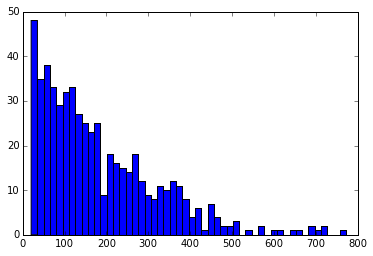

In [711]:
_ = pylab.hist(data['nunique'][data['nunique']!= 0], 50)

<matplotlib.colorbar.Colorbar instance at 0x1583ee9e0>

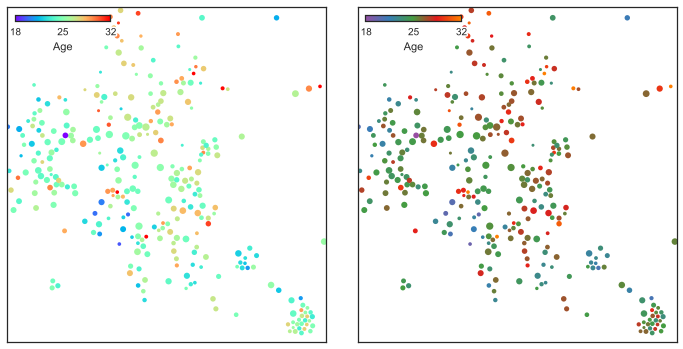

In [784]:
def setup_clusters(width=1500, xoffset=0, yoffset=0, **params):
    kwargs = dict(xticks=False, yticks=False, grid=False, tickmarks=False)
    kwargs.update(params)
    ax = setup(xr=[-width+xoffset,width+xoffset], yr=[-width+yoffset,width+yoffset], **kwargs)
    pylab.xticks([])
    pylab.yticks([])
    return ax
    
    
def plot_cluster(data, isgood=None, vmin=18, vmax=32, cmap=None, maxsize=50, sizescale=1.0, **kwargs):
    if isgood is None: isgood = (np.ones(data.shape) == 1)
    if cmap is None: cmap=make_cmap()
    agenorm = matplotlib.colors.Normalize(vmin, vmax, clip=True)
    index = np.where(isgood & (data['x'] != 0) & (data['y'] != 0))[0]
    s = np.clip(np.sqrt(data['nunique'][index]), 3, maxsize)*2*sizescale
    sca = pylab.scatter(data['x'][index], data['y'][index], label='Age',
                        s=s, c=data['age'][index], vmin=vmin, vmax=vmax, cmap=cmap, lw=0, **kwargs)
    return sca

def label_clusters(data, isgood=None, vmin=18, vmax=32, cmap=None, ax=None, sizescale=1.0):
    if isgood is None: isgood = (np.ones(data.shape) == 1)
    if cmap is None: cmap=make_cmap()
    if ax is None: ax = pylab.gca()
    
    agenorm = matplotlib.colors.Normalize(vmin, vmax, clip=True)
    xr,yr = pylab.xlim(), pylab.ylim()
    index = np.where(isgood & 
                     (data['x'] > xr[0]) & (data['x'] < xr[1]) & 
                     (data['y'] > yr[0]) & (data['y'] < yr[1]) & 
                     (data['x'] != 0) & (data['y'] != 0))[0]
    ii = np.argsort(data['nunique'][index])
    for x,y,label,age,s in data[index][['x','y','subreddit', 'age', 'nunique']][ii]:
        if len(label) == 0: continue
        color=cmap(agenorm(age))
#         s = np.clip(s, 4,12)*sizescale
        fs = np.clip(12*(s/200.0), 3, 12)*sizescale
        tmp = text(x,y,label, color=color,
                   ha='left', va='bottom', fontsize=fs,
                   clip_on=True, clip_path=ax.patch, outline=True)

        tmp.set_clip_path(ax.patch)


sub_width = 400
sub_xoffset = 70

setup_clusters(sub_width, sub_xoffset, figsize=(12,6), subplt=(1,2,1))
sca = plot_cluster(data, cmap=pylab.cm.rainbow, vmin=18, vmax=32)
icolorbar(sca, loc=2, borderpad=0.75, tickfmt='{:.0f}')

setup_clusters(sub_width, sub_xoffset, subplt=(1,2,2))
sca = plot_cluster(data, cmap=make_cmap(), vmin=18, vmax=32)
icolorbar(sca, loc=2, borderpad=0.75, tickfmt='{:.0f}')


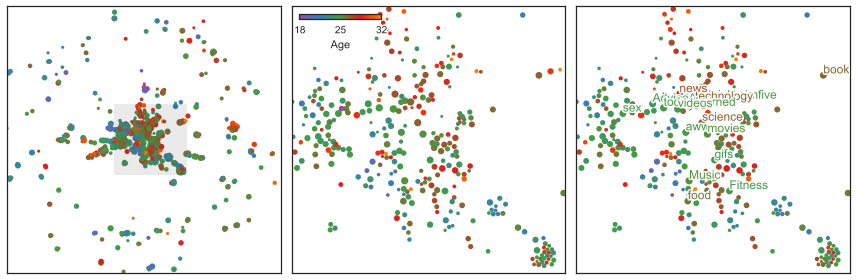

In [785]:
main_width = 1500
sub_width = 400
sub_xoffset = 70

setup_clusters(main_width, figsize=(12,4), subplt=(1,3,1))
box([-sub_width+sub_xoffset,sub_width+sub_xoffset], [-sub_width,sub_width], lw=0, alpha=0.1)
plot_cluster(data)

setup_clusters(sub_width, sub_xoffset, subplt=(1,3,2))
sca = plot_cluster(data)
icolorbar(sca, loc=2, borderpad=0.75, tickfmt='{:.0f}')


setup_clusters(sub_width, sub_xoffset, subplt=(1,3,3))
plot_cluster(data)
label_clusters(data, (data['nunique'] > 500))

    
pylab.tight_layout()
# pylab.savefig('/Users/ajmendez/Desktop/subreddits.png', dpi=200)

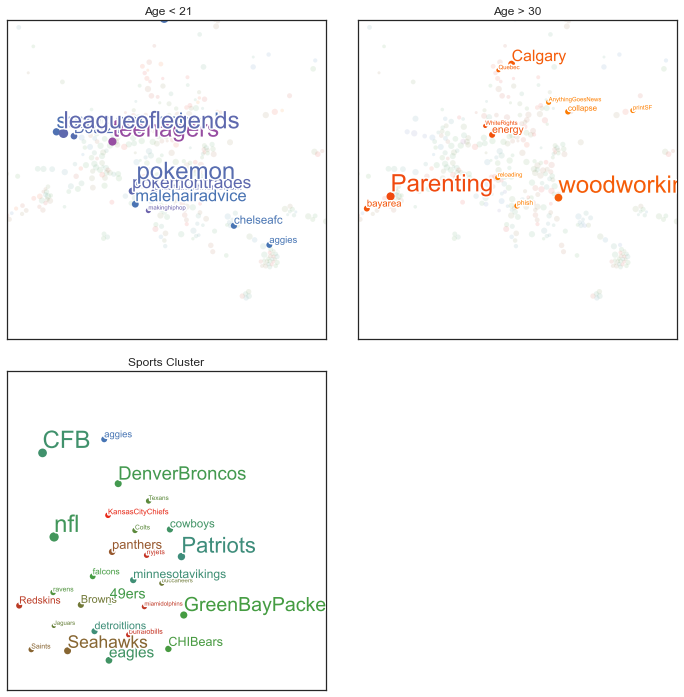

In [823]:
sub_width = 600
sub_xoffset = 20
sub_yoffset = -50
setup_clusters(sub_width, sub_xoffset, sub_yoffset, figsize=(12,12), subplt=(2,2,1), title='Age < 21')
plot_cluster(data, cmap=make_cmap(), alpha=0.1, maxsize=20)
isage = (data['age'] < 21) & (data['nunique'] > 10)
sca = plot_cluster(data, isage, sizescale=2.0)
label_clusters(data, isage, sizescale=2.0)

setup_clusters(sub_width, sub_xoffset, sub_yoffset, subplt=(2,2,2), title='Age > 30')
plot_cluster(data, cmap=make_cmap(), alpha=0.1, maxsize=20)
isage = (data['age'] > 30) & (data['nunique'] > 10)
sca = plot_cluster(data, isage, sizescale=2.0)
label_clusters(data, isage, sizescale=2.0)

sub_width = 60
sub_xoffset = 430
sub_yoffset = -330
setup_clusters(sub_width, sub_xoffset, sub_yoffset, subplt=(2,2,3), title='Sports Cluster')
plot_cluster(data, cmap=pylab.cm.Greys, alpha=0.1, maxsize=20)
isage = (data['nunique'] > 10)
sca = plot_cluster(data, isage, sizescale=2.0)
label_clusters(data, isage, sizescale=2.0)


In [ ]:
sub_width = 70
sub_xoffset = 1000
sub_yoffset = 150
setup_clusters(sub_width, sub_xoffset, sub_yoffset, subplt=(2,2,4))
plot_cluster(data, cmap=pylab.cm.Greys, alpha=0.1, maxsize=20)
isage = (data['nunique'] > 5) & (data['age'] > 0)
sca = plot_cluster(data, isage, sizescale=2.0)
label_clusters(data, isage, sizescale=2.0)
icolorbar(sca, loc=1)

javahelp      18.4
learnpython   22.5
compsci       23.5
java          23.6
techsupport   23.6
gamedev       24.4
Python        24.7
engineering   25.0
netsec        25.7
technology    26.6
web_design    26.9
webdev        27.0
linux         27.6
programming   28.3


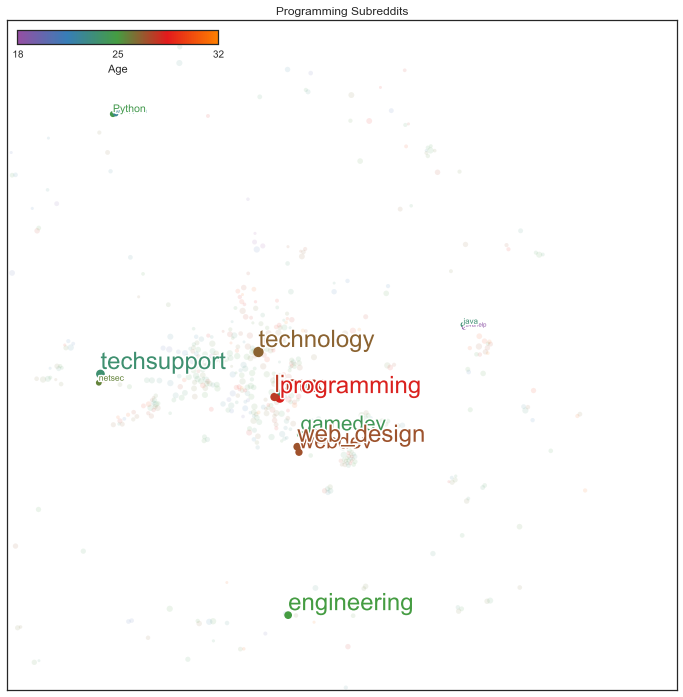

In [835]:
sub_width = 1450
sub_xoffset = 380
sub_yoffset = 100
setup_clusters(sub_width, sub_xoffset, sub_yoffset, figsize=(12,12),  title='Programming Subreddits')
plot_cluster(data, alpha=0.1, maxsize=20)
isage = (data['nunique'] > 10) & (data['age'] > 0) & (data['isprogramming'] ==1)
sca = plot_cluster(data, isage, sizescale=2.0)
icolorbar(sca)
label_clusters(data, isage, sizescale=2.0)
ii = np.argsort(data[isage]['age'])
for subreddit, age in data[isage][ii][['subreddit', 'age']]:
    print '{:12s} {:5.1f}'.format(subreddit, age)

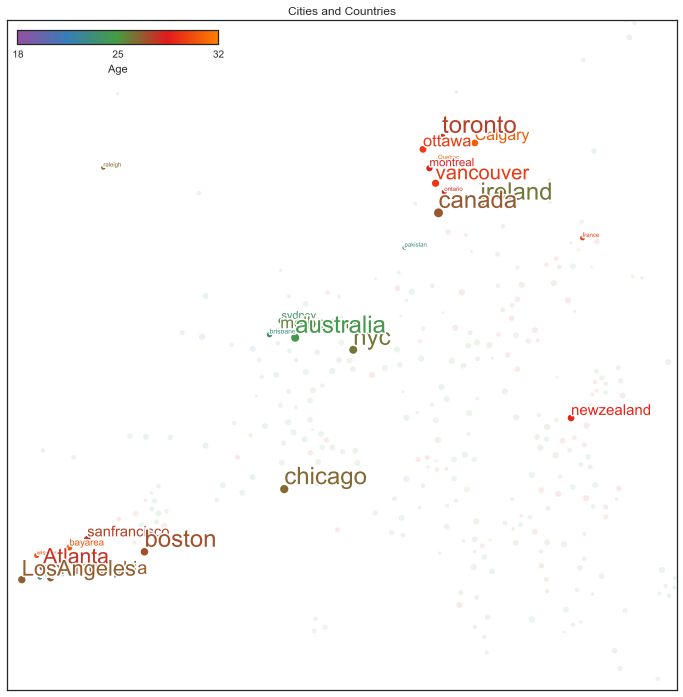

In [826]:
sub_width = 450
sub_xoffset = -180
sub_yoffset = 100
setup_clusters(sub_width, sub_xoffset, sub_yoffset, figsize=(12,12),  title='Cities and Countries')
plot_cluster(data, alpha=0.1, maxsize=20)
isage = (data['nunique'] > 10) & (data['age'] > 0) & (data['iscity'] ==1)
sca = plot_cluster(data, isage, sizescale=2.0)
icolorbar(sca)
label_clusters(data, isage, sizescale=2.0)

<Container object of 38 artists>

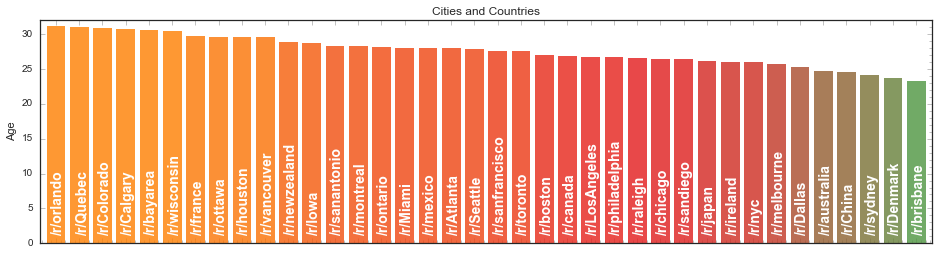

In [781]:
tmp = data[np.argsort(-data['age'])]
iscity = (tmp['nunique'] > 20) & (tmp['age'] > 10) & (tmp['iscity'] > 0)
ncity = len(np.where(iscity)[0])
cmap = make_cmap()

ax = setup(figsize=(16,4), grid=False,
           title='Cities and Countries',
           ylabel='Age', yr=[0, 32],
           xr=[-0.2, ncity+0.2], xtickv=np.arange(ncity)+0.5,
           xticknames=['' for x in tmp['subreddit'][iscity]], 
           xtickrotate=90)
for i, subreddit in enumerate(tmp['subreddit'][iscity]):
    pylab.text(i+0.6, 1, '/r/'+subreddit, 
               color='w', fontsize=14, fontweight='bold',
               ha='center', va='bottom', rotation=90)
    
# ax.set_xticklabels(tmp['subreddit'][iscity], rotation=90, ha='center')

pylab.bar(left=np.arange(ncity)+0.1, width=0.8,
          height=tmp['age'][iscity], lw=0, alpha=0.8,
          color=cmap(agenorm(tmp['age'][iscity])))


# Build data.json

In [836]:
vizit = json.load(open('/Users/ajmendez/data/reddit/vizit_data.json', 'r'))

In [892]:
ii = np.where(data['age'] > 0)
ageit = dict(nodes=[], edges=[])
node_ids = []
for node in vizit['nodes']:
    subreddit = node['label']
    
    i = np.where( (data['subreddit'] == subreddit) & (data['age'] > 0) )[0]
    if len(i) != 0:
        newnode = copy.copy(node)
        newnode['color'] = 'rgb({:0.0f}, {:0.0f}, {:0.0f})'.format(*data['rgba'][i][0][:-1]*256)
        newnode['size'] = 4.0*float(newnode['size'])
        newnode['age'] = float(data['age'][i])
    else:
        newnode = copy.copy(node)
        newnode['color'] = 'rgb({:0.0f}, {:0.0f}, {:0.0f})'.format(0,0,0)
        newnode['age'] = 0
        newnode['size'] = 0.5*float(newnode['size'])
        
    ageit['nodes'].append(newnode)
    node_ids.append(newnode['id'])

for edge in vizit['edges']:
    if (edge['source'] in node_ids) and (edge['target'] in node_ids):
        ageit['edges'].append(copy.copy(edge))
print 'Nodes: {:,d} Edges: {:,d}'.format(len(ageit['nodes']), len(ageit['edges']))

Nodes: 9,981 Edges: 142,881


In [888]:
data['age'][1]

25.225936285936285

In [820]:
pprint(vizit['nodes'][-2])
pprint(vizit['edges'][1])

{u'attributes': {u'Degree': u'331',
                 u'Modularity Class': u'5',
                 u'Subscribers': u'272565',
                 u'Weighted Degree': u'13416.0'},
 u'color': u'rgb(116,162,142)',
 u'id': u'19576',
 u'label': u'food',
 u'size': 7.9187421798706055,
 u'x': 3209.85791015625,
 u'y': 328.22381591796875}
{u'attributes': {u'weight': u'1.0'},
 u'id': u'89814',
 u'label': u'89814',
 u'source': u'31141',
 u'target': u'47969'}


In [890]:
json.dump(ageit, open('/Users/ajmendez/data/reddit/ageit_data.json', 'w'), indent=2)